In [1]:
import tensorflow as tf
from matplotlib import pyplot
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import glob
import os,cv2
import numpy as np

2023-06-21 13:56:07.713991: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
mask_weared_incorrect_path = glob.glob('Dataset/mask_weared_incorrect/*.png')
with_mask_path = glob.glob('Dataset/with_mask/*.png')
without_mask_path = glob.glob('Dataset/without_mask/*.png')
image_path = mask_weared_incorrect_path + with_mask_path + without_mask_path

label_incorrect_mask = []
label_mask = []
label_no_mask = []
labels = []
images = []

def prepare_data(image_path):

    for image_paths in image_path:
        # load the input image (224x224) and preprocess it
        image = cv2.imread(image_paths)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = img_to_array(image)
        image = preprocess_input(image)
      # update the data and labels lists, respectively
        images.append(image)

    # convert the data and labels to NumPy arrays
    data = np.array(images, dtype="float32")
    
    for i in mask_weared_incorrect_path:
        label_incorrect_mask.append(2) # represent that the person is wearing incorrect mask.
    for i in with_mask_path:
        label_mask.append(1)    # represent that the person is wearing mask.
    for a in without_mask_path:
        label_no_mask.append(0) # represent that the person is not wearing mask.

    label = label_incorrect_mask + label_mask + label_no_mask
    labels = np.array(label)

    return data, labels

data, labels = prepare_data(image_path)

In [3]:
def split_data(data, labels):
    (X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.2, shuffle=True, random_state=0)
    (X_train, X_val, y_train, y_val) = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=0)
    X_train = X_train.astype("float32") / 255.0
    X_test = X_test.astype("float32") / 255.0
    X_val = X_val.astype("float32") / 255.0
    y_train = to_categorical(y_train, 3)
    y_test = to_categorical(y_test, 3)
    y_val = to_categorical(y_val, 3)
    return X_train, X_test, X_val, y_train, y_test, y_val

X_train, X_test, X_val, y_train, y_test, y_val = split_data(data, labels)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(5748, 128, 128, 3)
(1797, 128, 128, 3)
(1437, 128, 128, 3)
(5748, 3)
(1797, 3)
(1437, 3)


In [4]:
datagen = ImageDataGenerator(        
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images)

datagen.fit(X_train)

In [5]:
# This cnn architecture refers to the below link:
# https://www.kaggle.com/code/muhammetzahitaydn/mask-detection-cnn-resnet50-efficientnet/notebook
model = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Dropout(0.3),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Dropout(0.3),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Dropout(0.3),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile model with cross-entropy loss and Adam optimizer
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

# Train model on training set


2023-06-21 13:56:17.863259: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-21 13:56:17.863998: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-21 13:56:17.892221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:68:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-06-21 13:56:17.892244: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-21 13:56:17.893958: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-21 13:56:17.894021: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

In [6]:
batch_size=32
early = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("mask_model.h5", monitor='val_accuracy', verbose=1, 
                            save_best_only=True, save_weights_only=False, mode='auto')
# learning_rate_reduction = ReduceLROnPlateau(
#     monitor = "val_accuracy",
#     factor = 0.5,
#     patience = 3,
#     verbose = 0,
#     min_lr = 0.00001
# )
history = model.fit(datagen.flow(X_train, y_train), batch_size=batch_size, epochs=50, validation_data=(X_val, y_val),callbacks=[checkpoint, early],
                    verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)
model.save('mask_model.h5')

2023-06-21 13:56:18.494625: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-21 13:56:18.506940: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3700000000 Hz


Epoch 1/50


2023-06-21 13:56:18.808784: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-21 13:56:18.956183: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-06-21 13:56:19.608399: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-06-21 13:56:19.661876: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


179/179 [==============================] - 27s 116ms/step - loss: 0.6780 - accuracy: 0.7066 - val_loss: 1.0127 - val_accuracy: 0.5379

Epoch 00001: val_accuracy improved from -inf to 0.53793, saving model to mask_model.h5
Epoch 2/50
179/179 [==============================] - 13s 70ms/step - loss: 0.4353 - accuracy: 0.8296 - val_loss: 0.8934 - val_accuracy: 0.6277

Epoch 00002: val_accuracy improved from 0.53793 to 0.62770, saving model to mask_model.h5
Epoch 3/50
179/179 [==============================] - 13s 70ms/step - loss: 0.3571 - accuracy: 0.8596 - val_loss: 0.7602 - val_accuracy: 0.6458

Epoch 00003: val_accuracy improved from 0.62770 to 0.64579, saving model to mask_model.h5
Epoch 4/50
179/179 [==============================] - 12s 70ms/step - loss: 0.2930 - accuracy: 0.8882 - val_loss: 0.3638 - val_accuracy: 0.8866

Epoch 00004: val_accuracy improved from 0.64579 to 0.88657, saving model to mask_model.h5
Epoch 5/50
179/179 [==============================] - 12s 70ms/step - los

In [7]:
_,acc = model.evaluate(X_test, y_test, verbose=0)
print('test:',acc)
_,acc = model.evaluate(X_train, y_train, verbose=0)
print('train:',acc)
_,acc = model.evaluate(X_val, y_val, verbose=0)
print('val:',acc)

test: 0.9621591567993164
train: 0.9705984592437744
val: 0.9491997361183167


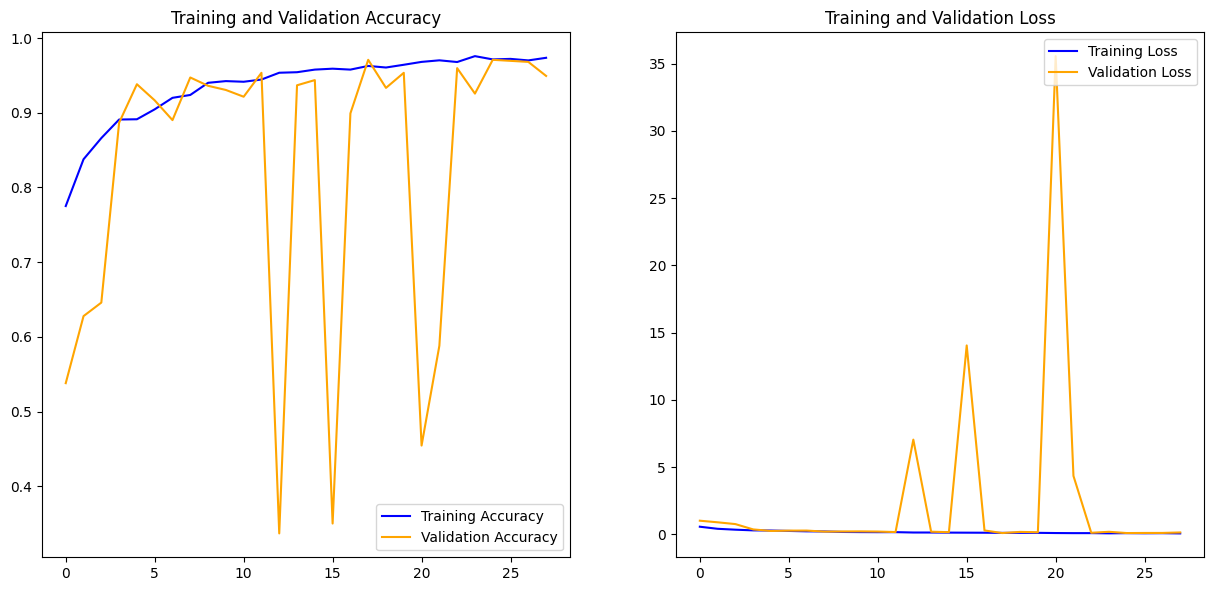

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


pyplot.figure(figsize=(15, 15))
pyplot.subplot(2, 2, 1)
pyplot.plot(acc, color="blue", label='Training Accuracy')
pyplot.plot(val_acc, color="orange", label='Validation Accuracy')
pyplot.legend(loc='lower right')
pyplot.title('Training and Validation Accuracy')

pyplot.subplot(2, 2, 2)
pyplot.plot(loss, color="blue", label='Training Loss')
pyplot.plot(val_loss, color="orange", label='Validation Loss')
pyplot.legend(loc='upper right')
pyplot.title('Training and Validation Loss')
#pyplot.show()
pyplot.savefig("Facemask_learningratereduction.png")

In [9]:
model1 = load_model("mask_model.h5")
model1_last_layer_output = Model(inputs=model1.input, outputs=model1.layers[-2].output)
model1_last_layer_output_train = model1_last_layer_output.predict(X_train, batch_size=32)
model1_last_layer_output_val = model1_last_layer_output.predict(X_val, batch_size=32)
model1_last_layer_output_test = model1_last_layer_output.predict(X_test, batch_size=32)


model2 = Sequential()

model2.add(Dense(3, activation='softmax'))
    # compile model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("mask_model2.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')
# learning_rate_reduction = ReduceLROnPlateau(
#     monitor = "val_accuracy",
#     factor = 0.5,
#     patience = 3,
#     verbose = 0,
#     min_lr = 0.00001
# )
model2.fit(model1_last_layer_output_train, y_train, epochs=50, validation_data=(model1_last_layer_output_val, y_val),callbacks=[checkpoint, early], batch_size=32)


_,acc = model2.evaluate(model1_last_layer_output_test, y_test, verbose=0)
print("test:",acc)
_, acc = model2.evaluate(model1_last_layer_output_train, y_train, verbose=0)
print("train:",acc)
_,acc = model2.evaluate(model1_last_layer_output_val, y_val, verbose=0)
print("val:",acc)


del model1_last_layer_output_train
del model1_last_layer_output_val
del model1_last_layer_output_test
del model1, model2
tf.keras.backend.clear_session()

Epoch 1/50
180/180 [==============================] - 0s 1ms/step - loss: 1.5040 - accuracy: 0.6181 - val_loss: 0.2313 - val_accuracy: 0.9123

Epoch 00001: val_accuracy improved from -inf to 0.91232, saving model to mask_model2.h5
Epoch 2/50
180/180 [==============================] - 0s 902us/step - loss: 0.1847 - accuracy: 0.9395 - val_loss: 0.1605 - val_accuracy: 0.9395

Epoch 00002: val_accuracy improved from 0.91232 to 0.93946, saving model to mask_model2.h5
Epoch 3/50
180/180 [==============================] - 0s 890us/step - loss: 0.1256 - accuracy: 0.9639 - val_loss: 0.1337 - val_accuracy: 0.9541

Epoch 00003: val_accuracy improved from 0.93946 to 0.95407, saving model to mask_model2.h5
Epoch 4/50
180/180 [==============================] - 0s 902us/step - loss: 0.1085 - accuracy: 0.9677 - val_loss: 0.1220 - val_accuracy: 0.9576

Epoch 00004: val_accuracy improved from 0.95407 to 0.95755, saving model to mask_model2.h5
Epoch 5/50
180/180 [==============================] - 0s 897u

In [10]:
model1 = load_model("mask_model.h5")
model1_last_layer_output = Model(inputs=model1.input, outputs=model1.layers[-2].output)
model1_last_layer_output_train = model1_last_layer_output.predict(X_train, batch_size=32)
model1_last_layer_output_val = model1_last_layer_output.predict(X_val, batch_size=32)
model1_last_layer_output_test = model1_last_layer_output.predict(X_test, batch_size=32)


model2 = Sequential()

model2.add(Dense(3, activation='softmax'))
    # compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("mask_model3.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')
# learning_rate_reduction = ReduceLROnPlateau(
#     monitor = "val_accuracy",
#     factor = 0.5,
#     patience = 3,
#     verbose = 0,
#     min_lr = 0.00001
# )
model2.fit(model1_last_layer_output_train, y_train, epochs=50, validation_data=(model1_last_layer_output_val, y_val),callbacks=[checkpoint, early], batch_size=32)


_,acc = model2.evaluate(model1_last_layer_output_test, y_test, verbose=0)
print("test:",acc)
_, acc = model2.evaluate(model1_last_layer_output_train, y_train, verbose=0)
print("train:",acc)
_,acc = model2.evaluate(model1_last_layer_output_val, y_val, verbose=0)
print("val:",acc)


del model1_last_layer_output_train
del model1_last_layer_output_val
del model1_last_layer_output_test
del model1, model2
tf.keras.backend.clear_session()

Epoch 1/50
180/180 [==============================] - 0s 1ms/step - loss: 0.7503 - accuracy: 0.7289 - val_loss: 0.1544 - val_accuracy: 0.9429

Epoch 00001: val_accuracy improved from -inf to 0.94294, saving model to mask_model3.h5
Epoch 2/50
180/180 [==============================] - 0s 900us/step - loss: 0.1340 - accuracy: 0.9562 - val_loss: 0.1278 - val_accuracy: 0.9576

Epoch 00002: val_accuracy improved from 0.94294 to 0.95755, saving model to mask_model3.h5
Epoch 3/50
180/180 [==============================] - 0s 893us/step - loss: 0.1051 - accuracy: 0.9642 - val_loss: 0.1179 - val_accuracy: 0.9582

Epoch 00003: val_accuracy improved from 0.95755 to 0.95825, saving model to mask_model3.h5
Epoch 4/50
180/180 [==============================] - 0s 920us/step - loss: 0.0936 - accuracy: 0.9685 - val_loss: 0.1129 - val_accuracy: 0.9638

Epoch 00004: val_accuracy improved from 0.95825 to 0.96381, saving model to mask_model3.h5
Epoch 5/50
180/180 [==============================] - 0s 903u